## Original testing code
File *predicting_leukocyte_class.py* adjusted for deprecated libraries and random file prediction.

In [1]:
import os, random
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import sys 
for cust in ['test_module','residual_network']:
    if cust in sys.modules:
        importlib.reload(sys.modules[cust])

import test_module as tm 

if not os.path.exists("../results"):
    os.mkdir("../results")

/home/gosia/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [50]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import backend as K

#from vis.utils import utils - changed for skimage because of errors
from skimage import io
import numpy as np
import sys
import os.path
import glob

#from scipy.misc import imsave - removed because it's no longer supported
sys.path.append("")
import residual_network


classes_dictionary_org = {'BAS':0, 'EBO':1, 'EOS':2, 'KSC':3, 'LYA':4, 'LYT':5, 'MMZ':6, 'MOB':7, 'MON':8, 'MYB':9, 'MYO':10, 'NGB':11, 'NGS':12, 'PMB':13, 'PMO':14 }
classes_dictionary = {value: key for key, value in classes_dictionary_org.items()}


abbreviation_dict = { 'NGS':'Neutrophil (segmented)', 
                      'NGB':'Neutrophil (band)',
                      'EOS':'Eosinophil',
                      'BAS':'Basophil',
                      'MON':'Monocyte',
                      'LYT':'Lymphocyte (typical)',
                      'LYA':'Lymphocyte (atypical)',
                      'KSC':'Smudge Cell',
                      'MYO':'Myeloblast',
                      'PMO':'Promyelocyte',
                      'MYB':'Myelocyte',
                      'MMZ':'Metamyelocyte',
                      'MOB':'Monoblast',
                      'EBO':'Erythroblast',
                      'PMB':'Promyelocyte (bilobed)'}

new_labels = [abbreviation_dict[classes_dictionary[i]] for i in range(15)]
merged_class = new_labels[1]
old_labels = [new_labels[0], f"{merged_class}(1)", f"{merged_class}(2)", *new_labels[2:]]

img_width, img_height = 400, 400

if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
else:
        input_shape = (img_width, img_height, 3)

In [3]:
weight_file_path = "weights.hdf5"

model = residual_network.model
model.load_weights(weight_file_path)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [4]:
def get_prediction(image_directory = "../data/image_data", cell_class=None):
    """
    Original code adapted into a function which randomly chooses file from
    <image_directory> and displays model's predictions for it.
    Argument <cell_class> should correspond to a subdirectory in a given <image_directory>, 
    when defined it'll narrow down the sample of images to choose from to a given 
    cell type.
    """

    if not cell_class:
        cell_class = "**"
    
    files = glob.glob(f"{image_directory}/{cell_class}/*.tiff")
    
    image_file_path = random.choice(files)
    subdirectory, filename = image_file_path.split("/")[-2:]

    img1 = io.imread(image_file_path)
    io.imshow(img1)
    plt.title(filename)
    plt.show()
    img1 = (img1[:,:,:3] *1./255)

    x = image.img_to_array(img1)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    preds_probs = model.predict(images, batch_size=1)
    preds_probs = np.array(preds_probs)
    preds_probs[:,1]+=preds_probs[:,2]
    preds_probs=np.delete(preds_probs,2,1)

    print ("\nNetwork output distribution: \n----------------------------------------------")
    for i in range(len(preds_probs[0])):
        print('{0:25}  {1:.5f}'.format(abbreviation_dict[classes_dictionary[i]], preds_probs[0][i]))

    if subdirectory in abbreviation_dict:
        print ("\nTRUE LABEL:\t"+abbreviation_dict[subdirectory])
        
    print ("\nPREDICTION:\t"+abbreviation_dict[classes_dictionary[np.argmax(preds_probs)]])


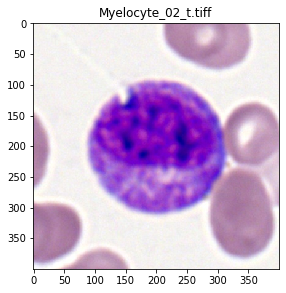


Network output distribution: 
----------------------------------------------
Basophil                   0.00004
Erythroblast               0.00000
Eosinophil                 0.00001
Smudge Cell                0.99937
Lymphocyte (atypical)      0.00008
Lymphocyte (typical)       0.00000
Metamyelocyte              0.00011
Monoblast                  0.00001
Monocyte                   0.00017
Myelocyte                  0.00000
Myeloblast                 0.00021
Neutrophil (band)          0.00000
Neutrophil (segmented)     0.00000
Promyelocyte (bilobed)     0.00000
Promyelocyte               0.00000

PREDICTION:	Smudge Cell


In [5]:
get_prediction(cell_class="MYELOCYTE")

## **Testing on a sample of data provided on CodeOcean**

In [6]:
def read_tiff(img):
    """ Make TIFF readable to data generator """  
    img = img[:,:,:3] 
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, preprocessing_function = read_tiff)

test_set = datagen.flow_from_directory("../data/image_data/", 
                                        class_mode = 'categorical',
                                       target_size = (400, 400),
                                      shuffle = False)

/home/gosia/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 146 images belonging to 16 classes.


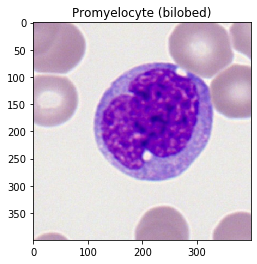

In [43]:
x, y = test_set.next()
plt.imshow(image.array_to_img(x[0]))
y = np.argmax(y[0])
plt.title(old_labels[y])
plt.show()

In [44]:
# evaluate model
acc, loss = model.evaluate(test_set)
print(f"Test accuracy:\t{acc}\nTest loss: {loss}")

# get predictions for test images
y_pred = model.predict(test_set)

5/5 [==============================] - 95s 16s/step - loss: 12.7114 - accuracy: 0.0302
Test accuracy:	12.797232627868652
Test loss: 0.04109589010477066


In [45]:
y_pred_mod = np.array(y_pred)
y_pred_mod [:,1]+=y_pred_mod [:,2]
y_pred_mod =np.delete(y_pred_mod,2,1)

In [87]:
import sklearn, matplotlib
sklearn.__version__
matplotlib.__version__

'3.1.1'

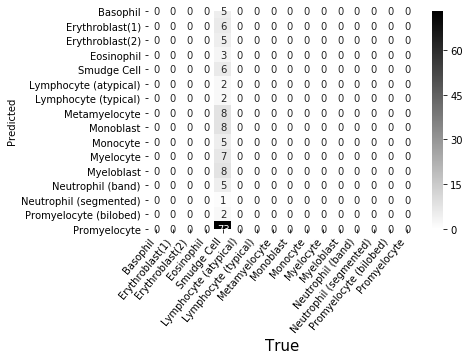

In [85]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

#plt.figure(figsize = (11,6))
ax = sns.heatmap(confusion_matrix(test_set.classes, y_pred.argmax(axis=1)),
                 xticklabels = old_labels, yticklabels = old_labels,  
                 cmap="binary", annot=True)
plt.xticks(rotation=50, ha="right")
plt.xlabel("True", fontsize=15)
plt.ylabel("Predicted",  fontsize=10)
plt.show()

In [79]:
tm.plot_CM_heatmap(test_set.classes, y_pred.argmax(axis=1), labels=old_labels, save=False, norm="true")

TypeError: confusion_matrix() got an unexpected keyword argument 'normalize'

<Figure size 864x576 with 0 Axes>

## **Testing on a sample of data provided in The Cancer Imaging Archive**

Test sample consists of 160 images from the original dataset downloaded from TCIA (~10 observations per class).

In [8]:
image_directory ="../data/TCIA_data"

files = glob.glob(f"{image_directory}/**/*.tiff")
images_list = []
labels = []

# the loop transforms the 160 images in a way presented in the original testing script 
# and merges them in one np.array object to feed the model

for file in files:
    subdirectory, filename = file.split("/")[-2:]
    
    img1 = io.imread(file)
    img1 = (img1[:,:,:3] *1./255)

    x = image.img_to_array(img1)
    x = np.expand_dims(x, axis=0)
    
    
    labels.append(classes_dictionary_org[subdirectory])
    images_list.append(x)

images = np.vstack(images_list)

preds_probs = model.predict(images, batch_size = 16)

# possible result of merging two classes into one after the network had been trained
# - from the original code

preds_probs = np.array(preds_probs)
preds_probs[:,1]+=preds_probs[:,2]
preds_probs=np.delete(preds_probs,2,1)

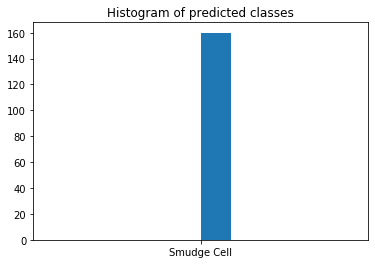

In [9]:
# visualization of prediction frequencies
labeled_preds = [abbreviation_dict[classes_dictionary[preds_probs.argmax(axis=1)[i]]] for i in range(160)]
plt.title("Histogram of predicted classes")
plt.hist(labeled_preds)
plt.show()

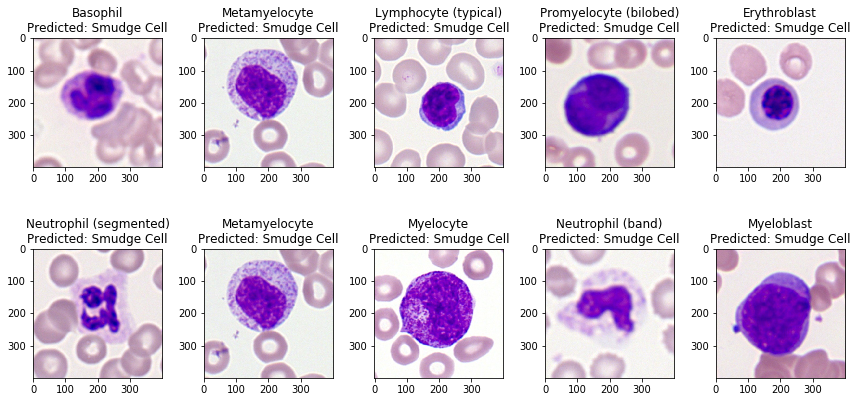

In [11]:
# display of 10 images from the sample along with 
# their predicted classes

indices = [random.randint(0,160) for i in range(10)]

fig, axs = plt.subplots(2,5, figsize=(12,6))
fig.tight_layout() 

for n,idx in enumerate(indices):
    plt.subplot(2,5,n+1)
    orig = abbreviation_dict[classes_dictionary[labels[idx]]]
    pred = abbreviation_dict[classes_dictionary[preds_probs.argmax(axis=1)[idx]]]
    plt.title(f"{orig}\nPredicted: {pred}")
    plt.imshow(images[idx,:,:,:])